# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset
from tqdm import tqdm

# Constants

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
IMAGE_SIZE = 32

EMBEDDING_SIZE = 128
TEMPERATURE = 0.01

PRETRAINING_EPOCHS = 100
FULL_DATA_EPOCHS = 50
SUBSET_DATA_EPOCHS = 30

BATCH_SIZE = 512
INITIAL_LR = 1e-3
FINAL_LR = 1e-5
WARMUP_EPOCHS = 10

SEED = 42

# Data augmentation

In [5]:
cifar10 = torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True)
cifar10[0]

100%|██████████| 170M/170M [00:09<00:00, 18.4MB/s] 


Extracting ../datasets/cifar-10-python.tar.gz to ../datasets


(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [6]:
contrastive_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        torchvision.transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2
                ),
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
        ),
    ]
)

In [7]:
def denormalize(x):
    x = x * torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    x = x + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    return x

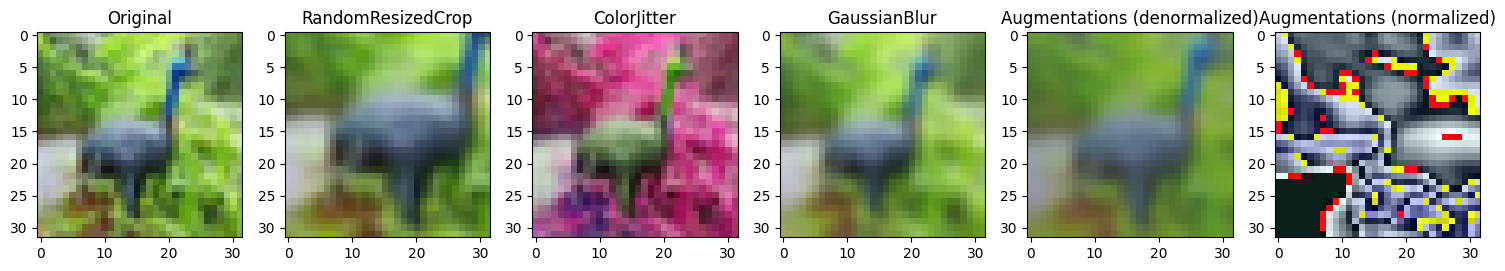

In [8]:
img_pil, label = cifar10[6]
to_tensor = transforms.ToImage()
to_pil = transforms.ToPILImage()

fig, axs = plt.subplots(1, 6, figsize=(15, 5))

axs[0].imshow(img_pil)
axs[0].set_title("Original")

axs[1].imshow(to_pil(transforms.RandomResizedCrop(size=IMAGE_SIZE)(to_tensor(img_pil))))
axs[1].set_title("RandomResizedCrop")

axs[2].imshow(to_pil(transforms.ColorJitter(hue=0.5)(to_tensor(img_pil))))
axs[2].set_title("ColorJitter")

axs[3].imshow(to_pil(transforms.GaussianBlur(kernel_size=3)(to_tensor(img_pil))))
axs[3].set_title("GaussianBlur")

axs[4].imshow(to_pil(denormalize(contrastive_transform(to_tensor(img_pil)))))
axs[4].set_title("Augmentations (denormalized)")

axs[5].imshow(to_pil(contrastive_transform(to_tensor(img_pil))))
axs[5].set_title("Augmentations (normalized)")

plt.tight_layout()
plt.show()

# Contrastive dataset

In [9]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, augmentations):
        self.dataset = dataset
        self.augmentations = augmentations

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.augmentations(img), self.augmentations(img)

    def __len__(self):
        return len(self.dataset)

# Loss

In [10]:
class NTXent(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        assert batch_size == z_j.shape[0], "Batch sizes must match"

        z_i = F.normalize(z_i, dim=-1)
        z_j = F.normalize(z_j, dim=-1)

        z = torch.cat([z_i, z_j], dim=0)  # [2 * batch_size, embedding_size]

        similarity_matrix = (
            F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
            / self.temperature
        )  # [2 * batch_size, 2 * batch_size]

        sim_i_j = torch.diag(similarity_matrix, batch_size)  # [batch_size]
        sim_j_i = torch.diag(similarity_matrix, -batch_size)  # [batch_size]

        positive_samples = torch.cat([sim_i_j, sim_j_i], dim=0).unsqueeze(
            1
        )  # [2 * batch_size, 1]

        # mask = torch.ones(
        #     batch_size * 2, batch_size * 2, dtype=torch.bool
        # ).fill_diagonal_(False)  # [2 * batch_size, 2 * batch_size]

        # for i in range(batch_size):
        #     mask[i, batch_size + i] = False
        #     mask[batch_size + i, i] = False

        mask = torch.zeros(
            2 * batch_size,
            2 * batch_size,
            dtype=torch.bool,
            device=similarity_matrix.device,
        )
        indices = torch.arange(batch_size, device=similarity_matrix.device)
        mask.scatter_(1, indices, True)
        mask.scatter_(0, indices + batch_size, True)

        negative_samples = similarity_matrix[mask].view(
            batch_size * 2, -1
        )  # [2 * batch_size, batch_size - 2]
        logits = torch.cat(
            [positive_samples, negative_samples], dim=-1
        )  # [2 * batch_size, batch_size - 1]
        labels = torch.zeros(batch_size * 2, dtype=torch.long).to(
            logits.device
        )  # [2 * batch_size]
        loss = F.cross_entropy(logits, labels, reduction="sum")
        return loss / (2 * batch_size)

# Encoder Model

In [11]:
class Encoder(nn.Module):
    def __init__(self, encoder: nn.Module, projection_size: int):
        super().__init__()

        assert hasattr(encoder, "fc"), "Base encoder must have a fc layer"

        self.encoder = encoder
        self.embedding_size = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(self.embedding_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        return x

# Data Split

In [15]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True),
    [45000, 5000],
    generator=torch.Generator().manual_seed(SEED),
)
test_dataset = torchvision.datasets.CIFAR10(
    root="../datasets", train=False, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
eval_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.Resize(size=IMAGE_SIZE),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
        ),
    ]
)

# Self-Supervised Pretraining

In [17]:
train_contrastive_dataset = ContrastiveDataset(train_dataset, contrastive_transform)
valid_contrastive_dataset = ContrastiveDataset(valid_dataset, eval_transform)
test_contrastive_dataset = ContrastiveDataset(test_dataset, eval_transform)

train_loader = torch.utils.data.DataLoader(
    train_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

In [19]:
encoder = Encoder(
    encoder=torchvision.models.resnet18(weights=None),
    projection_size=EMBEDDING_SIZE,
).to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = NTXent(temperature=TEMPERATURE).to(device)
scaler = GradScaler(device=device)
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(
            optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_EPOCHS
        ),
        CosineAnnealingLR(
            optimizer, T_max=PRETRAINING_EPOCHS - WARMUP_EPOCHS, eta_min=FINAL_LR
        ),
    ],
    milestones=[WARMUP_EPOCHS],
)

In [ ]:
train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(PRETRAINING_EPOCHS):
    encoder.train()
    train_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Train]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            combined = torch.cat([imgs_i, imgs_j], dim=0)
            embeddings = encoder(combined)
            z_i, z_j = torch.split(embeddings, BATCH_SIZE)
            loss = criterion(z_i, z_j)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_train_loss = train_loss / num_batches
    train_losses.append(epoch_avg_train_loss)

    encoder.eval()
    val_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(
        val_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Valid]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        with torch.no_grad():
            with autocast(device_type=device.type):
                combined = torch.cat([imgs_i, imgs_j], dim=0)
                embeddings = encoder(combined)
                z_i, z_j = torch.split(embeddings, BATCH_SIZE)
                loss = criterion(z_i, z_j)

        val_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_val_loss = val_loss / num_batches
    val_losses.append(epoch_avg_val_loss)

    if epoch_avg_val_loss < best_val_loss:
        best_val_loss = epoch_avg_val_loss
        torch.save(encoder.state_dict(), "cifar10_encoder_best.pth")
        print(f"Saved new best model with val_loss: {best_val_loss:.4f}")

    scheduler.step()

torch.save(encoder.state_dict(), "cifar10_encoder.pth")

In [ ]:
def get_encoder(pretrained: bool):
    encoder = Encoder(
        encoder=torchvision.models.resnet18(weights=None),
        projection_size=EMBEDDING_SIZE,
    ).to(device)
    if pretrained:
        encoder.load_state_dict(
            torch.load(
                "/kaggle/input/cifar10_encoder3/pytorch/default/1/cifar10_encoder.pth",
                weights_only=True,
            )
        )
    encoder.projection_head = nn.Identity()
    return encoder

# Classifier Training Loop

In [21]:
def train_supervised(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int,
    warmup_epochs: int,
    initial_lr: float,
    final_lr: float,
    experiment_name: str,
    device=device,
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = GradScaler(device=device)
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(
                optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs
            ),
            CosineAnnealingLR(
                optimizer, T_max=epochs - warmup_epochs, eta_min=final_lr
            ),
        ],
        milestones=[warmup_epochs],
    )

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]")

        for i, (imgs, labels) in enumerate(progress_bar):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                logits = model(imgs)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(
                {"loss": loss.item(), "acc": 100 * correct / total}
            )

        epoch_train_acc = 100 * correct / total
        epoch_avg_train_loss = train_loss / (i + 1)
        train_losses.append(epoch_avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Valid]")

        with torch.no_grad():
            for i, (imgs, labels) in enumerate(progress_bar):
                imgs, labels = imgs.to(device), labels.to(device)

                with autocast(device_type=device.type):
                    logits = model(imgs)
                    loss = criterion(logits, labels)

                val_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix(
                    {"loss": loss.item(), "acc": 100 * correct / total}
                )

        epoch_val_acc = 100 * correct / total
        epoch_avg_val_loss = val_loss / (i + 1)
        val_losses.append(epoch_avg_val_loss)

        if epoch_avg_val_loss < best_val_loss:
            best_val_loss = epoch_avg_val_loss
            torch.save(model.state_dict(), f"cifar10_{experiment_name}.pth")

        scheduler.step()

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_avg_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
            f"Val Loss: {epoch_avg_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
        )

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy ({experiment_name}): {test_acc:.2f}%")

    return train_losses, val_losses, test_acc

In [22]:
class Classifier(nn.Module):
    def __init__(self, encoder: Encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = torch.nn.Sequential(
            nn.Linear(self.encoder.embedding_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.classifier(x)
        return x

# Data Preparation

In [23]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.5, 1.0)),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1
                )
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]
        ),
    ]
)
train_transformed = TransformedDataset(train_dataset, train_transform)
valid_transformed = TransformedDataset(valid_dataset, eval_transform)
test_transformed = TransformedDataset(test_dataset, eval_transform)

train_loader = torch.utils.data.DataLoader(
    train_transformed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

# Self-Supervised Learning + Fine-Tuning

In [ ]:
classifier_finetuned = Classifier(
    encoder=get_encoder(pretrained=True), num_classes=10
).to(device)
for param in classifier_finetuned.encoder.parameters():
    param.requires_grad = False

finetuned_train_losses, finetuned_val_losses, finetuned_test_acc = train_supervised(
    classifier_finetuned,
    train_loader,
    val_loader,
    test_loader,
    epochs=FULL_DATA_EPOCHS,
    warmup_epochs=WARMUP_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    experiment_name="finetuned",
    device=device,
)

Epoch 1/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 1.6139, Train Acc: 47.39%, Val Loss: 1.1818, Val Acc: 58.86%, LR: 0.000190


Epoch 2/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 1.1874, Train Acc: 58.70%, Val Loss: 1.0659, Val Acc: 62.52%, LR: 0.000280


Epoch 3/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 1.1349, Train Acc: 60.19%, Val Loss: 1.0443, Val Acc: 62.74%, LR: 0.000370


Epoch 4/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 1.1008, Train Acc: 61.19%, Val Loss: 1.0352, Val Acc: 63.30%, LR: 0.000460


Epoch 5/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 1.0833, Train Acc: 62.07%, Val Loss: 0.9932, Val Acc: 64.30%, LR: 0.000550


Epoch 6/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 1.0639, Train Acc: 62.70%, Val Loss: 0.9833, Val Acc: 65.24%, LR: 0.000640


Epoch 7/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 1.0396, Train Acc: 63.39%, Val Loss: 0.9672, Val Acc: 66.36%, LR: 0.000730


Epoch 8/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 1.0257, Train Acc: 64.09%, Val Loss: 0.9620, Val Acc: 65.68%, LR: 0.000820


Epoch 9/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 1.0128, Train Acc: 64.45%, Val Loss: 0.9874, Val Acc: 65.26%, LR: 0.000910


Epoch 10/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 1.0066, Train Acc: 64.64%, Val Loss: 0.9691, Val Acc: 65.52%, LR: 0.001000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 1.0017, Train Acc: 64.76%, Val Loss: 0.9431, Val Acc: 66.80%, LR: 0.000998


Epoch 12/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.9780, Train Acc: 65.61%, Val Loss: 0.9350, Val Acc: 66.98%, LR: 0.000994


Epoch 13/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.9657, Train Acc: 66.02%, Val Loss: 0.9480, Val Acc: 66.84%, LR: 0.000986


Epoch 14/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.9513, Train Acc: 66.61%, Val Loss: 0.9727, Val Acc: 66.06%, LR: 0.000976


Epoch 15/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.9492, Train Acc: 66.36%, Val Loss: 0.9254, Val Acc: 68.20%, LR: 0.000962


Epoch 16/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.9384, Train Acc: 66.96%, Val Loss: 0.9231, Val Acc: 67.74%, LR: 0.000946


Epoch 17/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.9338, Train Acc: 67.06%, Val Loss: 0.9168, Val Acc: 68.08%, LR: 0.000927


Epoch 18/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.9167, Train Acc: 67.86%, Val Loss: 0.9459, Val Acc: 67.22%, LR: 0.000905


Epoch 19/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.9074, Train Acc: 68.02%, Val Loss: 0.9128, Val Acc: 68.04%, LR: 0.000881


Epoch 20/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.9039, Train Acc: 68.00%, Val Loss: 0.9109, Val Acc: 68.04%, LR: 0.000855


Epoch 21/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.8919, Train Acc: 68.50%, Val Loss: 0.9206, Val Acc: 68.28%, LR: 0.000826


Epoch 22/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.8904, Train Acc: 68.62%, Val Loss: 0.9137, Val Acc: 68.18%, LR: 0.000796


Epoch 23/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.8841, Train Acc: 68.80%, Val Loss: 0.9109, Val Acc: 68.38%, LR: 0.000764


Epoch 24/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.8752, Train Acc: 69.13%, Val Loss: 0.9103, Val Acc: 68.46%, LR: 0.000730


Epoch 25/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.8604, Train Acc: 69.82%, Val Loss: 0.9003, Val Acc: 68.88%, LR: 0.000694


Epoch 26/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.8572, Train Acc: 70.09%, Val Loss: 0.9244, Val Acc: 68.08%, LR: 0.000658


Epoch 27/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.8517, Train Acc: 70.02%, Val Loss: 0.9318, Val Acc: 67.72%, LR: 0.000621


Epoch 28/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.8458, Train Acc: 70.31%, Val Loss: 0.8859, Val Acc: 68.78%, LR: 0.000582


Epoch 29/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.8362, Train Acc: 70.59%, Val Loss: 0.8977, Val Acc: 69.16%, LR: 0.000544


Epoch 30/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.8252, Train Acc: 70.96%, Val Loss: 0.8998, Val Acc: 69.24%, LR: 0.000505


Epoch 31/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 31/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.8226, Train Acc: 70.86%, Val Loss: 0.8919, Val Acc: 69.28%, LR: 0.000466


Epoch 32/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 32/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.8193, Train Acc: 71.20%, Val Loss: 0.8889, Val Acc: 69.40%, LR: 0.000428


Epoch 33/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 33/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.8098, Train Acc: 71.41%, Val Loss: 0.8983, Val Acc: 69.24%, LR: 0.000389


Epoch 34/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 34/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.7939, Train Acc: 71.98%, Val Loss: 0.8853, Val Acc: 69.84%, LR: 0.000352


Epoch 35/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 35/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.7956, Train Acc: 71.98%, Val Loss: 0.8975, Val Acc: 69.18%, LR: 0.000316


Epoch 36/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 36/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.7889, Train Acc: 72.38%, Val Loss: 0.8779, Val Acc: 69.84%, LR: 0.000280


Epoch 37/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 37/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.7903, Train Acc: 72.22%, Val Loss: 0.8863, Val Acc: 70.12%, LR: 0.000246


Epoch 38/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 38/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.7847, Train Acc: 72.49%, Val Loss: 0.8901, Val Acc: 69.36%, LR: 0.000214


Epoch 39/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 39/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.7799, Train Acc: 72.53%, Val Loss: 0.8873, Val Acc: 69.60%, LR: 0.000184


Epoch 40/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 40/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.7764, Train Acc: 72.68%, Val Loss: 0.8940, Val Acc: 69.80%, LR: 0.000155


Epoch 41/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 41/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.7707, Train Acc: 72.73%, Val Loss: 0.8819, Val Acc: 70.02%, LR: 0.000129


Epoch 42/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 42/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.7667, Train Acc: 73.21%, Val Loss: 0.8861, Val Acc: 69.88%, LR: 0.000105


Epoch 43/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 43/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.7642, Train Acc: 73.18%, Val Loss: 0.8875, Val Acc: 69.50%, LR: 0.000083


Epoch 44/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 44/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.7626, Train Acc: 73.31%, Val Loss: 0.8887, Val Acc: 69.80%, LR: 0.000064


Epoch 45/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 45/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.7536, Train Acc: 73.40%, Val Loss: 0.8833, Val Acc: 70.08%, LR: 0.000048


Epoch 46/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 46/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.7558, Train Acc: 73.43%, Val Loss: 0.8855, Val Acc: 69.78%, LR: 0.000034


Epoch 47/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 47/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.7564, Train Acc: 73.36%, Val Loss: 0.8860, Val Acc: 69.82%, LR: 0.000024


Epoch 48/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 48/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.7525, Train Acc: 73.74%, Val Loss: 0.8851, Val Acc: 69.76%, LR: 0.000016


Epoch 49/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 49/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.7538, Train Acc: 73.49%, Val Loss: 0.8827, Val Acc: 69.86%, LR: 0.000012


Epoch 50/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 50/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.7498, Train Acc: 73.79%, Val Loss: 0.8843, Val Acc: 69.98%, LR: 0.000010


/tmp/ipykernel_73/3313409929.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"cifar10_{experiment_name}.pth"))


Test Accuracy (finetuned): 69.37%


# Supervised Learninig Baseline

In [30]:
supervised_model = Classifier(
    encoder=get_encoder(pretrained=False),
    num_classes=10,
).to(device)

supervised_train_losses, supervised_val_losses, supervised_test_acc = train_supervised(
    supervised_model,
    train_loader,
    val_loader,
    test_loader,
    epochs=FULL_DATA_EPOCHS,
    warmup_epochs=WARMUP_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    experiment_name="supervised",
    device=device,
)

Epoch 1/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 2.2431, Train Acc: 16.56%, Val Loss: 2.1265, Val Acc: 24.06%, LR: 0.000190


Epoch 2/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 2.1355, Train Acc: 22.26%, Val Loss: 2.0246, Val Acc: 27.34%, LR: 0.000280


Epoch 3/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 2.0915, Train Acc: 23.78%, Val Loss: 1.9728, Val Acc: 29.14%, LR: 0.000370


Epoch 4/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 2.0703, Train Acc: 24.61%, Val Loss: 1.9611, Val Acc: 29.24%, LR: 0.000460


Epoch 5/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 2.0531, Train Acc: 25.73%, Val Loss: 1.9484, Val Acc: 30.00%, LR: 0.000550


Epoch 6/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 2.0442, Train Acc: 25.95%, Val Loss: 1.9345, Val Acc: 30.50%, LR: 0.000640


Epoch 7/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 2.0333, Train Acc: 26.31%, Val Loss: 1.9272, Val Acc: 30.64%, LR: 0.000730


Epoch 8/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 2.0289, Train Acc: 26.43%, Val Loss: 1.9285, Val Acc: 31.22%, LR: 0.000820


Epoch 9/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 2.0183, Train Acc: 26.47%, Val Loss: 1.9220, Val Acc: 31.30%, LR: 0.000910


Epoch 10/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 2.0095, Train Acc: 26.98%, Val Loss: 1.9246, Val Acc: 30.62%, LR: 0.001000


Epoch 11/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 2.0070, Train Acc: 27.12%, Val Loss: 1.8995, Val Acc: 32.02%, LR: 0.000998


Epoch 12/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 1.9957, Train Acc: 27.23%, Val Loss: 1.8880, Val Acc: 32.44%, LR: 0.000994


Epoch 13/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 1.9924, Train Acc: 27.85%, Val Loss: 1.8958, Val Acc: 31.18%, LR: 0.000986


Epoch 14/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 1.9891, Train Acc: 28.00%, Val Loss: 1.8831, Val Acc: 31.68%, LR: 0.000976


Epoch 15/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 1.9826, Train Acc: 28.29%, Val Loss: 1.8818, Val Acc: 32.38%, LR: 0.000962


Epoch 16/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 1.9718, Train Acc: 28.52%, Val Loss: 1.8911, Val Acc: 31.90%, LR: 0.000946


Epoch 17/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 1.9690, Train Acc: 28.57%, Val Loss: 1.8688, Val Acc: 32.18%, LR: 0.000927


Epoch 18/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 1.9717, Train Acc: 28.34%, Val Loss: 1.8611, Val Acc: 33.12%, LR: 0.000905


Epoch 19/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 1.9669, Train Acc: 28.97%, Val Loss: 1.8578, Val Acc: 33.54%, LR: 0.000881


Epoch 20/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 1.9575, Train Acc: 28.92%, Val Loss: 1.8607, Val Acc: 33.66%, LR: 0.000855


Epoch 21/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 1.9560, Train Acc: 28.98%, Val Loss: 1.8515, Val Acc: 33.82%, LR: 0.000826


Epoch 22/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 1.9561, Train Acc: 29.14%, Val Loss: 1.8598, Val Acc: 32.70%, LR: 0.000796


Epoch 23/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 1.9525, Train Acc: 29.50%, Val Loss: 1.8608, Val Acc: 33.70%, LR: 0.000764


Epoch 24/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 1.9429, Train Acc: 29.52%, Val Loss: 1.8364, Val Acc: 34.18%, LR: 0.000730


Epoch 25/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 1.9390, Train Acc: 30.05%, Val Loss: 1.8443, Val Acc: 34.02%, LR: 0.000694


Epoch 26/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 1.9392, Train Acc: 29.68%, Val Loss: 1.8397, Val Acc: 34.60%, LR: 0.000658


Epoch 27/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 1.9369, Train Acc: 29.68%, Val Loss: 1.8386, Val Acc: 33.54%, LR: 0.000621


Epoch 28/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 1.9328, Train Acc: 30.32%, Val Loss: 1.8407, Val Acc: 34.14%, LR: 0.000582


Epoch 29/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 1.9325, Train Acc: 30.11%, Val Loss: 1.8408, Val Acc: 34.24%, LR: 0.000544


Epoch 30/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 1.9356, Train Acc: 30.05%, Val Loss: 1.8331, Val Acc: 34.38%, LR: 0.000505


Epoch 31/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 31/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 1.9348, Train Acc: 30.10%, Val Loss: 1.8397, Val Acc: 34.00%, LR: 0.000466


Epoch 32/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 32/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 1.9227, Train Acc: 30.42%, Val Loss: 1.8235, Val Acc: 34.70%, LR: 0.000428


Epoch 33/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 33/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 1.9217, Train Acc: 30.57%, Val Loss: 1.8204, Val Acc: 35.00%, LR: 0.000389


Epoch 34/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 34/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 1.9280, Train Acc: 30.32%, Val Loss: 1.8322, Val Acc: 34.68%, LR: 0.000352


Epoch 35/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 35/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 1.9244, Train Acc: 30.59%, Val Loss: 1.8308, Val Acc: 34.24%, LR: 0.000316


Epoch 36/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 36/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 1.9191, Train Acc: 30.68%, Val Loss: 1.8207, Val Acc: 35.60%, LR: 0.000280


Epoch 37/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 37/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 1.9156, Train Acc: 31.31%, Val Loss: 1.8180, Val Acc: 35.48%, LR: 0.000246


Epoch 38/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 38/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 1.9135, Train Acc: 30.87%, Val Loss: 1.8116, Val Acc: 35.14%, LR: 0.000214


Epoch 39/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 39/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 1.9107, Train Acc: 31.12%, Val Loss: 1.8191, Val Acc: 35.04%, LR: 0.000184


Epoch 40/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 40/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 1.9098, Train Acc: 31.28%, Val Loss: 1.8098, Val Acc: 35.50%, LR: 0.000155


Epoch 41/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 41/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 1.9080, Train Acc: 31.21%, Val Loss: 1.8108, Val Acc: 35.30%, LR: 0.000129


Epoch 42/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 42/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 1.9022, Train Acc: 31.88%, Val Loss: 1.8079, Val Acc: 35.68%, LR: 0.000105


Epoch 43/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 43/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 1.9047, Train Acc: 31.38%, Val Loss: 1.8155, Val Acc: 35.44%, LR: 0.000083


Epoch 44/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 44/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 1.9065, Train Acc: 31.10%, Val Loss: 1.8066, Val Acc: 35.90%, LR: 0.000064


Epoch 45/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 45/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 1.8992, Train Acc: 31.29%, Val Loss: 1.8033, Val Acc: 36.00%, LR: 0.000048


Epoch 46/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 46/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 1.9030, Train Acc: 31.44%, Val Loss: 1.8032, Val Acc: 35.86%, LR: 0.000034


Epoch 47/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 47/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 1.9040, Train Acc: 31.22%, Val Loss: 1.8033, Val Acc: 35.74%, LR: 0.000024


Epoch 48/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 48/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 1.9073, Train Acc: 31.25%, Val Loss: 1.8039, Val Acc: 36.02%, LR: 0.000016


Epoch 49/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 49/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 1.9026, Train Acc: 31.31%, Val Loss: 1.8018, Val Acc: 35.78%, LR: 0.000012


Epoch 50/50 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 50/50 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 1.9066, Train Acc: 31.56%, Val Loss: 1.8042, Val Acc: 36.02%, LR: 0.000010


/tmp/ipykernel_73/3313409929.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"cifar10_{experiment_name}.pth"))


Test Accuracy (supervised): 35.16%


# Training on 10% of CIFAR10

In [32]:
def create_subset(dataset, fraction=0.1):
    total_size = len(dataset)
    subset_size = int(total_size * fraction)

    indices = torch.randperm(total_size, generator=torch.Generator().manual_seed(SEED))
    subset_indices = indices[:subset_size]

    return torch.utils.data.Subset(dataset, subset_indices)


train_subset = create_subset(train_transformed, fraction=0.1)
print(
    f"Full training set size: {len(train_transformed)}, 10% subset size: {len(train_subset)}"
)

subset_train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Full training set size: 45000, 10% subset size: 4500


## Finetuning on 10% CIFAR10

In [ ]:
classifier_finetuned_10pct = Classifier(
    encoder=get_encoder(pretrained=True), num_classes=10
).to(device)

finetuned_10pct_train_losses, finetuned_10pct_val_losses, finetuned_10pct_test_acc = (
    train_supervised(
        classifier_finetuned_10pct,
        subset_train_loader,
        val_loader,
        test_loader,
        epochs=SUBSET_DATA_EPOCHS,
        warmup_epochs=5,
        initial_lr=INITIAL_LR,
        final_lr=FINAL_LR,
        experiment_name="finetuned_10pct",
        device=device,
    )
)

Epoch 1/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 2.2552, Train Acc: 18.87%, Val Loss: 2.0967, Val Acc: 29.56%, LR: 0.000280


Epoch 2/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 1.8539, Train Acc: 42.56%, Val Loss: 1.5489, Val Acc: 51.14%, LR: 0.000460


Epoch 3/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 1.4078, Train Acc: 53.36%, Val Loss: 1.2326, Val Acc: 56.74%, LR: 0.000640


Epoch 4/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 1.2391, Train Acc: 56.69%, Val Loss: 1.1640, Val Acc: 58.42%, LR: 0.000820


Epoch 5/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 1.1693, Train Acc: 58.27%, Val Loss: 1.1498, Val Acc: 58.52%, LR: 0.001000


Epoch 6/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 1.1418, Train Acc: 60.04%, Val Loss: 1.1645, Val Acc: 59.12%, LR: 0.000996


Epoch 7/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 1.0968, Train Acc: 61.56%, Val Loss: 1.1469, Val Acc: 60.00%, LR: 0.000984


Epoch 8/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 1.0618, Train Acc: 62.31%, Val Loss: 1.0933, Val Acc: 61.46%, LR: 0.000965


Epoch 9/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 1.0387, Train Acc: 62.76%, Val Loss: 1.0830, Val Acc: 61.64%, LR: 0.000939


Epoch 10/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 1.0258, Train Acc: 64.40%, Val Loss: 1.1025, Val Acc: 61.06%, LR: 0.000905


Epoch 11/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/30, Train Loss: 1.0008, Train Acc: 65.36%, Val Loss: 1.1113, Val Acc: 61.18%, LR: 0.000866


Epoch 12/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 0.9988, Train Acc: 65.18%, Val Loss: 1.0979, Val Acc: 61.36%, LR: 0.000821


Epoch 13/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 0.9664, Train Acc: 66.49%, Val Loss: 1.0880, Val Acc: 61.86%, LR: 0.000770


Epoch 14/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 0.9602, Train Acc: 66.42%, Val Loss: 1.1361, Val Acc: 60.40%, LR: 0.000716


Epoch 15/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/30, Train Loss: 0.9622, Train Acc: 65.89%, Val Loss: 1.0703, Val Acc: 62.02%, LR: 0.000658


Epoch 16/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/30, Train Loss: 0.9214, Train Acc: 67.96%, Val Loss: 1.0638, Val Acc: 62.00%, LR: 0.000598


Epoch 17/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/30, Train Loss: 0.9071, Train Acc: 67.71%, Val Loss: 1.0916, Val Acc: 61.80%, LR: 0.000536


Epoch 18/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/30, Train Loss: 0.9066, Train Acc: 68.07%, Val Loss: 1.0856, Val Acc: 62.28%, LR: 0.000474


Epoch 19/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/30, Train Loss: 0.8864, Train Acc: 68.91%, Val Loss: 1.0795, Val Acc: 62.42%, LR: 0.000412


Epoch 20/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/30, Train Loss: 0.8996, Train Acc: 68.09%, Val Loss: 1.0579, Val Acc: 62.56%, LR: 0.000352


Epoch 21/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/30, Train Loss: 0.8661, Train Acc: 70.02%, Val Loss: 1.0677, Val Acc: 62.96%, LR: 0.000294


Epoch 22/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/30, Train Loss: 0.8587, Train Acc: 69.98%, Val Loss: 1.0587, Val Acc: 63.28%, LR: 0.000240


Epoch 23/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/30, Train Loss: 0.8525, Train Acc: 70.11%, Val Loss: 1.0561, Val Acc: 62.94%, LR: 0.000189


Epoch 24/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/30, Train Loss: 0.8477, Train Acc: 70.07%, Val Loss: 1.0535, Val Acc: 62.96%, LR: 0.000144


Epoch 25/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/30, Train Loss: 0.8486, Train Acc: 70.44%, Val Loss: 1.0600, Val Acc: 62.96%, LR: 0.000105


Epoch 26/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/30, Train Loss: 0.8356, Train Acc: 70.82%, Val Loss: 1.0618, Val Acc: 62.86%, LR: 0.000071


Epoch 27/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/30, Train Loss: 0.8412, Train Acc: 70.62%, Val Loss: 1.0577, Val Acc: 62.80%, LR: 0.000045


Epoch 28/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/30, Train Loss: 0.8443, Train Acc: 70.87%, Val Loss: 1.0565, Val Acc: 62.82%, LR: 0.000026


Epoch 29/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/30, Train Loss: 0.8350, Train Acc: 70.62%, Val Loss: 1.0552, Val Acc: 62.96%, LR: 0.000014


Epoch 30/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/30, Train Loss: 0.8407, Train Acc: 70.80%, Val Loss: 1.0539, Val Acc: 62.88%, LR: 0.000010


/tmp/ipykernel_73/3313409929.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"cifar10_{experiment_name}.pth"))


Test Accuracy (finetuned_10pct): 63.12%


## Supervised training on 10% CIFAR10

In [34]:
classifier_supervised_10pct = Classifier(
    encoder=get_encoder(pretrained=False),
    num_classes=10,
).to(device)

(
    supervised_10pct_train_losses,
    supervised_10pct_val_losses,
    supervised_10pct_test_acc,
) = train_supervised(
    classifier_supervised_10pct,
    subset_train_loader,
    val_loader,
    test_loader,
    epochs=SUBSET_DATA_EPOCHS,
    warmup_epochs=5,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    experiment_name="supervised_10pct",
    device=device,
)

Epoch 1/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 2.3112, Train Acc: 10.89%, Val Loss: 2.2995, Val Acc: 12.38%, LR: 0.000280


Epoch 2/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 2.2687, Train Acc: 14.67%, Val Loss: 2.2903, Val Acc: 13.68%, LR: 0.000460


Epoch 3/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 2.2270, Train Acc: 18.24%, Val Loss: 2.2337, Val Acc: 17.10%, LR: 0.000640


Epoch 4/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 2.1809, Train Acc: 20.38%, Val Loss: 2.1407, Val Acc: 25.02%, LR: 0.000820


Epoch 5/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 2.1481, Train Acc: 22.27%, Val Loss: 2.0913, Val Acc: 25.74%, LR: 0.001000


Epoch 6/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 2.1181, Train Acc: 23.11%, Val Loss: 2.0436, Val Acc: 26.90%, LR: 0.000996


Epoch 7/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 2.1019, Train Acc: 24.71%, Val Loss: 2.0564, Val Acc: 26.16%, LR: 0.000984


Epoch 8/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 2.1207, Train Acc: 23.07%, Val Loss: 2.0316, Val Acc: 26.66%, LR: 0.000965


Epoch 9/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 2.0964, Train Acc: 24.22%, Val Loss: 2.0274, Val Acc: 26.08%, LR: 0.000939


Epoch 10/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 2.0970, Train Acc: 24.91%, Val Loss: 2.0379, Val Acc: 25.70%, LR: 0.000905


Epoch 11/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/30, Train Loss: 2.0829, Train Acc: 24.33%, Val Loss: 2.0233, Val Acc: 26.64%, LR: 0.000866


Epoch 12/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 2.0610, Train Acc: 25.24%, Val Loss: 2.0167, Val Acc: 27.58%, LR: 0.000821


Epoch 13/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 2.0717, Train Acc: 23.67%, Val Loss: 2.0087, Val Acc: 27.14%, LR: 0.000770


Epoch 14/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 2.0709, Train Acc: 25.27%, Val Loss: 2.0183, Val Acc: 26.82%, LR: 0.000716


Epoch 15/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/30, Train Loss: 2.0553, Train Acc: 25.96%, Val Loss: 2.0102, Val Acc: 27.50%, LR: 0.000658


Epoch 16/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/30, Train Loss: 2.0313, Train Acc: 27.02%, Val Loss: 2.0015, Val Acc: 26.98%, LR: 0.000598


Epoch 17/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/30, Train Loss: 2.0347, Train Acc: 25.58%, Val Loss: 1.9960, Val Acc: 27.96%, LR: 0.000536


Epoch 18/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/30, Train Loss: 2.0444, Train Acc: 25.56%, Val Loss: 1.9957, Val Acc: 27.40%, LR: 0.000474


Epoch 19/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/30, Train Loss: 2.0346, Train Acc: 26.80%, Val Loss: 1.9902, Val Acc: 28.24%, LR: 0.000412


Epoch 20/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/30, Train Loss: 2.0560, Train Acc: 25.76%, Val Loss: 1.9811, Val Acc: 28.26%, LR: 0.000352


Epoch 21/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/30, Train Loss: 2.0493, Train Acc: 25.42%, Val Loss: 1.9792, Val Acc: 28.42%, LR: 0.000294


Epoch 22/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/30, Train Loss: 2.0245, Train Acc: 26.76%, Val Loss: 1.9903, Val Acc: 28.22%, LR: 0.000240


Epoch 23/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/30, Train Loss: 2.0339, Train Acc: 27.13%, Val Loss: 1.9753, Val Acc: 28.70%, LR: 0.000189


Epoch 24/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/30, Train Loss: 2.0331, Train Acc: 26.80%, Val Loss: 1.9773, Val Acc: 28.56%, LR: 0.000144


Epoch 25/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/30, Train Loss: 2.0351, Train Acc: 27.09%, Val Loss: 1.9790, Val Acc: 28.88%, LR: 0.000105


Epoch 26/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/30, Train Loss: 2.0472, Train Acc: 26.29%, Val Loss: 1.9751, Val Acc: 29.28%, LR: 0.000071


Epoch 27/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/30, Train Loss: 2.0255, Train Acc: 27.20%, Val Loss: 1.9771, Val Acc: 28.64%, LR: 0.000045


Epoch 28/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/30, Train Loss: 2.0278, Train Acc: 26.42%, Val Loss: 1.9782, Val Acc: 28.70%, LR: 0.000026


Epoch 29/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/30, Train Loss: 2.0287, Train Acc: 26.62%, Val Loss: 1.9762, Val Acc: 28.72%, LR: 0.000014


Epoch 30/30 [Train]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/30 [Valid]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/30, Train Loss: 2.0285, Train Acc: 26.49%, Val Loss: 1.9760, Val Acc: 28.82%, LR: 0.000010


/tmp/ipykernel_73/3313409929.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"cifar10_{experiment_name}.pth"))


Test Accuracy (supervised_10pct): 29.40%


# Results Comparison

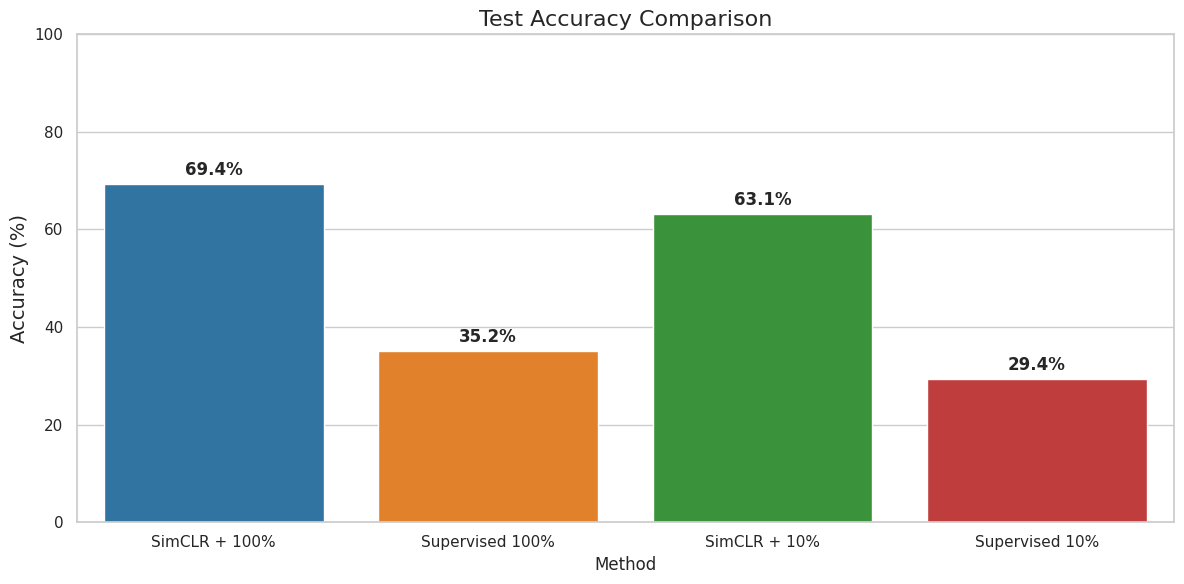

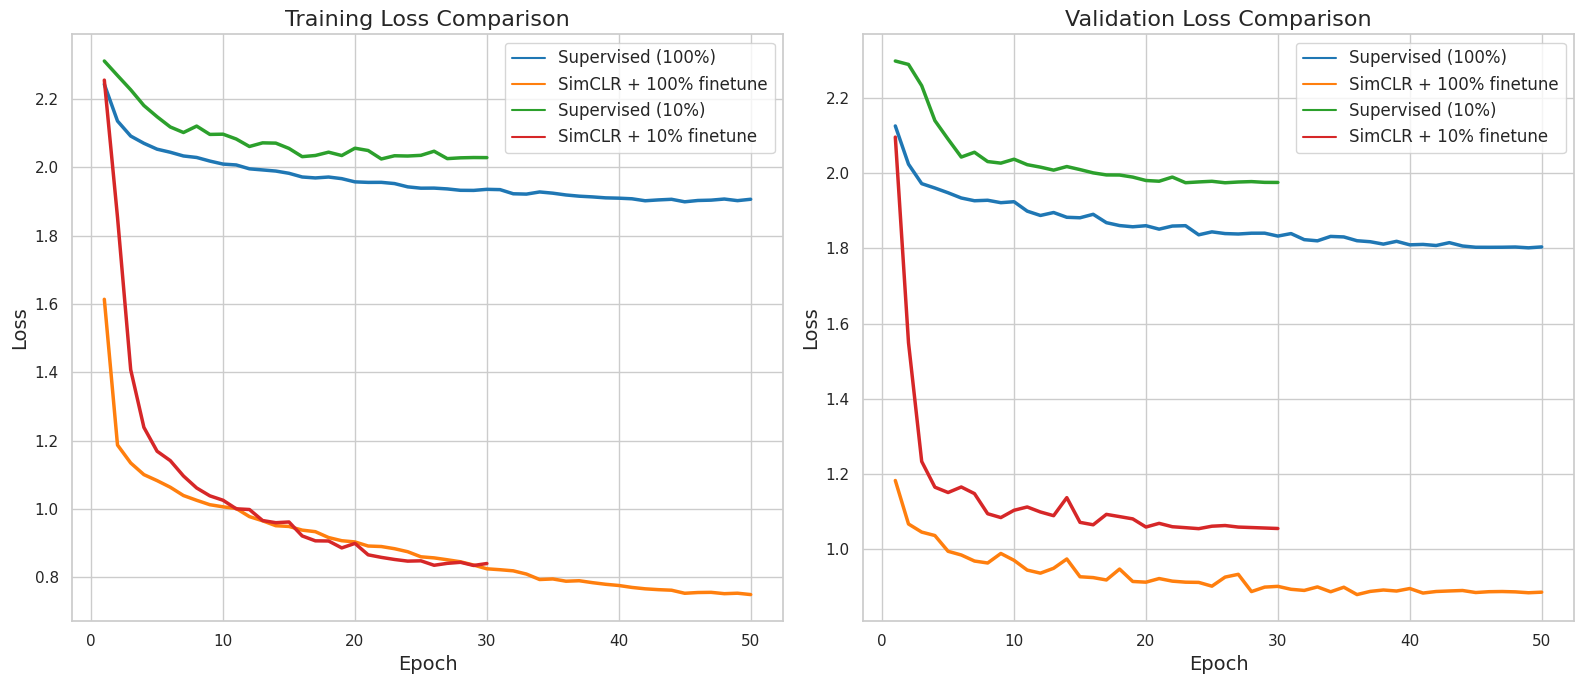

Test accuracy comparison:
SimCLR + 100%: 69.37%
Supervised 100%: 35.16%
SimCLR + 10%: 63.12%
Supervised 10%: 29.40%


In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

plt.figure(figsize=(12, 6))
methods = ["SimCLR + 100%", "Supervised 100%", "SimCLR + 10%", "Supervised 10%"]
accuracies = [
    finetuned_test_acc,
    supervised_test_acc,
    finetuned_10pct_test_acc,
    supervised_10pct_test_acc,
]

accuracy_df = pd.DataFrame(
    {
        "Method": methods,
        "Accuracy": accuracies,
        "Color": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
    }
)

ax = sns.barplot(
    x="Method", y="Accuracy", data=accuracy_df, palette=accuracy_df["Color"]
)
ax.set_title("Test Accuracy Comparison", fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_ylim(0, 100)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{accuracies[i]:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(16, 7))

epochs = range(1, len(supervised_train_losses) + 1)
data = []

for values, name in [
    (supervised_train_losses, "Supervised (100%)"),
    (finetuned_train_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_train_losses, "Supervised (10%)"),
    (finetuned_10pct_train_losses, "SimCLR + 10% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append({"Epoch": epoch, "Loss": value, "Method": name, "Type": "Training"})

for values, name in [
    (supervised_val_losses, "Supervised (100%)"),
    (finetuned_val_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_val_losses, "Supervised (10%)"),
    (finetuned_10pct_val_losses, "SimCLR + 10% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append(
            {"Epoch": epoch, "Loss": value, "Method": name, "Type": "Validation"}
        )

losses_df = pd.DataFrame(data)

plt.subplot(1, 2, 1)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Training"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Training Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Validation"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Validation Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.tight_layout()
plt.savefig("loss_comparison.png", dpi=300, bbox_inches="tight")
plt.show()